In [115]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

In [116]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [117]:
train=train.drop_duplicates(keep='first')
test=test.drop_duplicates(keep='first')

In [118]:
## 1. EDA 및 전처리(baseline: MSE 98)

### 1) 상가비율

tmp = train.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
train = pd.merge(train,total[['단지코드','상가비율']],on='단지코드',how='left')

tmp = test.groupby(['단지코드','임대건물구분']).count().iloc[:,:1].reset_index()
store = tmp[tmp['임대건물구분']=='상가'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'상가수'})
apt = tmp[tmp['임대건물구분']=='아파트'].reset_index(drop=True)[['단지코드','총세대수']].rename(columns={'총세대수':'아파트수'})
total = pd.merge(apt,store,on='단지코드',how='left').fillna(0)
total['상가비율'] = total.apply(lambda x : x['상가수']/(x['아파트수']+x['상가수']),axis=1)
test = pd.merge(test,total[['단지코드','상가비율']],on='단지코드',how='left')

### 2) 세대당가능주차면수

train['세대당_가능주차면수'] = train.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)
test['세대당_가능주차면수'] = test.apply(lambda x : x['단지내주차면수']/x['총세대수'],axis=1)

### 3) 공가비율

train['공가비율'] = train.apply(lambda x : x['공가수']/x['총세대수'],axis=1)
test['공가비율'] = test.apply(lambda x : x['공가수']/x['총세대수'],axis=1)

### 4) 대형전용면적

level = 85

train['대형전용면적'] = train['전용면적'].apply(lambda x : 1 if x>level else 0)
test['대형전용면적'] = test['전용면적'].apply(lambda x : 1 if x>level else 0)

### 5) 공급유형
#- 공공임대 5년/10년 $\rightarrow$ 공공임대(단기)

train.loc[train.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'
test.loc[test.공급유형.isin(['공공임대(5년)', '공공임대(10년)']), '공급유형'] = '공공임대(단기)'

#- 1차원으로 합치기

not_unique = ['공급유형','전용면적','임대건물구분','전용면적별세대수','대형전용면적','임대보증금','임대료','자격유형']

train_one = train.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)
test_one = test.drop(not_unique,axis=1).drop_duplicates().reset_index(drop=True)

#- 전용면적별세대수 채우기

for i in train['공급유형'].unique():
    train_one[i] = 0
    test_one[i] = 0

sample = pd.DataFrame(train.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = train_one[train_one['단지코드']==code].index
    train_one.loc[ind,col] = val

sample = pd.DataFrame(test.groupby(['단지코드','공급유형']).sum()['전용면적별세대수']).reset_index()
for i in sample.index:
    code = sample.loc[i,'단지코드']
    col = sample.loc[i,'공급유형']
    val = sample.loc[i,'전용면적별세대수']  # 전용면적별세대수
    ind = test_one[test_one['단지코드']==code].index
    test_one.loc[ind,col] = val

### 6) 임대료 임대보증금 : 평균

sample = train.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['임대료','임대보증금']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

### 연면적 / 전용면적은 나중에 drop

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2) # 12345 중에 2가 제일 좋음

sample = train.groupby('단지코드').mean()[['전용면적']].reset_index()
train_one=pd.merge(train_one, sample, on="단지코드", how="left")

sample = test.groupby('단지코드').mean()[['전용면적']].reset_index()
test_one=pd.merge(test_one, sample, on="단지코드", how="left")

train_one["연면적new"]=train_one.연면적
test_one["연면적new"]=test_one.연면적

train_one.loc[(train_one.연면적new<train_one.전용면적), "연면적new"]=np.nan
test_one.loc[(test_one.연면적new<test_one.전용면적), "연면적new"]=np.nan

#train_one.isna().sum() # 63

#test_one.isna().sum() #23

im=train_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
im = pd.DataFrame(imputer.fit_transform(im),
                     columns = im.columns)

train_one["연면적new"]=im["연면적new"]

imp=test_one[["단지내주차면수", "총세대수", "전용면적", "연면적new"]]
imp = pd.DataFrame(imputer.fit_transform(imp),
                     columns = imp.columns)

test_one["연면적new"]=imp["연면적new"]

### 7) 대형전용면적 총개수

sample = pd.DataFrame(train.groupby('단지코드')['대형전용면적'].sum()).reset_index()
train_one = pd.merge(train_one, sample, on="단지코드", how="left")

sample = pd.DataFrame(test.groupby('단지코드')['대형전용면적'].sum()).reset_index()
test_one = pd.merge(test_one, sample, on="단지코드", how="left")

### 8) 변수제거

col = ['단지명','도로명주소','subway_name','임대상가', '전용면적']

train_one = train_one.drop(col,axis=1)
test_one = test_one.drop(col,axis=1)

In [119]:
train_up = train_one[train_one['단지내주차면수']>=987].reset_index(drop=True)
train_down = train_one[train_one['단지내주차면수']<987].reset_index(drop=True)

test_up = test_one[test_one['단지내주차면수']>=987].reset_index(drop=True)
test_down = test_one[test_one['단지내주차면수']<987].reset_index(drop=True)

In [120]:
def areafunc(x):
    if x in ['제주특별자치도','경상남도','부산광역시']:
        return 0
    elif x in ['광주광역시','세종특별자치시','경상북도','전라북도','서울특별시']:
        return 1
    elif x in ['대구광역시']:
        return 2
    else: 
        return 3

In [128]:
train_up['지역'] = train_up['지역'].apply(lambda x : areafunc(x))
test_up['지역'] = test_up['지역'].apply(lambda x : areafunc(x))

train_up = train_up.join(pd.get_dummies(train_up['지역'],prefix='area')).iloc[:,:-1]
test_up = test_up.join(pd.get_dummies(test_up['지역'],prefix='area')).iloc[:,:-1]

In [129]:
X = train_up.drop(columns=['단지코드','등록차량수','지역','상가비율', "연면적"],axis=1)
X = X[['총세대수', '공가수', '지하철역', '버스정류장', '단지내주차면수',  '연면적new','위도', '경도',
       'subway_dist', '환승역 수', '총인구수', '세대당_인구', '남/여비율', '남/여_0~19세',
       '남/여_20~39세', '남/여_40~69세', '남/여_70세이상', '0~19세_비율', '20~39세_비율',
       '40~69세_비율', '70세이상_비율', '세대당_가능주차면수', '공가비율', '국민임대', '영구임대',
       '공공임대(단기)', '장기전세', '행복주택', '공공임대(분납)', '공공분양', '공공임대(50년)', '임대료',
       '임대보증금', '대형전용면적', 'area_0', 'area_1', 'area_2']]
y = train_up['등록차량수']

In [130]:
from sklearn.preprocessing import StandardScaler
x = StandardScaler().fit_transform(X)

In [131]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)
pc = pca.fit_transform(x)
principalDf = pd.DataFrame(data = pc)
#pd.concat([pd.DataFrame(X.columns),pd.DataFrame(pca.components_).transpose()],axis = 1)

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,총세대수,-2.126608e-01,2.263202e-01,1.628822e-01,-1.465139e-01,-1.632553e-01,6.760628e-02,1.466499e-01,-9.256128e-02,3.065526e-01,-5.768885e-02,-6.631792e-02,2.044671e-01,7.057645e-02,-1.337811e-01,-4.145556e-02
1,공가수,-1.780456e-01,-2.290788e-01,2.518261e-02,-1.473542e-01,-6.711718e-02,3.584236e-01,5.997230e-02,2.018670e-01,-4.011282e-02,4.861307e-02,-3.717842e-02,1.778648e-01,1.173319e-02,1.597449e-01,7.083988e-02
2,지하철역,7.028373e-02,1.660623e-01,1.765759e-01,5.814821e-02,-5.746447e-02,-1.623681e-01,3.515310e-01,-2.604876e-02,-2.649289e-01,3.118954e-02,-1.606937e-01,-3.281351e-01,-3.906560e-02,1.481970e-01,-1.090796e-01
3,버스정류장,-3.670347e-02,1.595125e-01,9.306126e-02,6.507667e-02,-1.576054e-01,-6.559745e-02,2.360457e-01,-1.426768e-01,-5.866350e-02,-2.320755e-01,1.145685e-01,2.650297e-01,1.897037e-02,6.736530e-01,-1.982695e-01
4,단지내주차면수,-7.411516e-02,2.341950e-01,2.978136e-02,-1.340844e-01,-1.296159e-01,7.640798e-02,3.272513e-01,-2.564683e-02,1.531002e-01,-2.195771e-02,5.751361e-02,3.713779e-01,3.057129e-01,-3.478101e-01,-7.656033e-02
5,연면적new,1.728069e-01,2.348134e-01,-1.380143e-01,-2.640923e-02,5.216929e-02,2.835767e-01,4.726400e-02,-1.751135e-01,-3.040218e-02,1.038554e-01,3.261915e-02,-9.302280e-02,8.791394e-02,1.963273e-01,-1.160903e-01
6,위도,-1.017870e-01,-1.618118e-01,5.136803e-02,-7.715805e-02,4.153863e-01,9.979049e-02,2.103288e-01,-5.819456e-02,1.026878e-01,6.533272e-02,-2.014036e-01,-9.159452e-02,8.874433e-02,-1.058465e-01,-2.065666e-01
7,경도,7.002881e-03,2.355589e-01,2.097997e-01,-9.511992e-02,-1.228115e-01,7.929205e-02,-3.248738e-01,-8.097189e-04,-3.504654e-01,-6.052340e-02,7.238371e-02,5.562695e-02,2.947035e-02,-2.033180e-01,-6.184871e-02
8,subway_dist,-7.456780e-02,-8.889535e-02,-2.338288e-01,2.210707e-01,-6.110033e-02,-4.601007e-02,2.147554e-01,-3.502136e-02,1.464887e-01,1.194382e-02,4.106843e-01,1.264744e-01,-1.366563e-01,2.002690e-02,4.503223e-01
9,환승역 수,4.255343e-02,-1.772587e-02,-1.725947e-01,-4.262418e-02,-1.958126e-01,-8.217052e-02,-1.642969e-01,-1.331428e-01,2.926075e-01,-1.937118e-01,-5.079908e-01,-1.756176e-01,1.361766e-01,1.245283e-01,3.729884e-01


In [132]:
pca.explained_variance_

array([5.80257948, 4.93024465, 3.22340083, 3.09063659, 2.65876587,
       2.37991612, 1.94067869, 1.5029765 , 1.36502013, 1.26127593,
       1.09596706, 0.9494912 , 0.93520917, 0.82839298, 0.72626189])

/Users/seungji/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

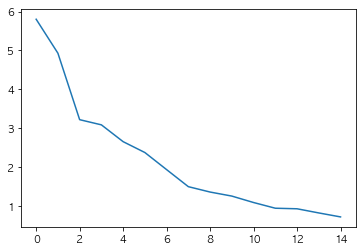

In [136]:
sns.lineplot(range(len(pca.explained_variance_)),pca.explained_variance_)

In [141]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7)
pc = pca.fit_transform(x)
principalDf = pd.DataFrame(data = pc)
#pd.concat([pd.DataFrame(X.columns),pd.DataFrame(pca.components_).transpose()],axis = 1)

In [152]:
X = pd.DataFrame(pc)

In [144]:
X = pd.DataFrame(pca.components_).transpose()

In [146]:
X.columns = ["pc1","pc2","pc3","pc4" ,"pc5","pc6","pc7"]
X

,pc1,pc2,pc3,pc4,pc5,pc6,pc7
0,-2.126608e-01,2.263202e-01,1.628822e-01,-1.465139e-01,-1.632553e-01,6.760628e-02,1.466499e-01
1,-1.780456e-01,-2.290788e-01,2.518261e-02,-1.473542e-01,-6.711718e-02,3.584236e-01,5.997230e-02
2,7.028373e-02,1.660623e-01,1.765759e-01,5.814821e-02,-5.746447e-02,-1.623681e-01,3.515310e-01
3,-3.670347e-02,1.595125e-01,9.306126e-02,6.507667e-02,-1.576054e-01,-6.559745e-02,2.360457e-01
4,-7.411516e-02,2.341950e-01,2.978136e-02,-1.340844e-01,-1.296159e-01,7.640798e-02,3.272513e-01
5,1.728069e-01,2.348134e-01,-1.380143e-01,-2.640923e-02,5.216929e-02,2.835767e-01,4.726400e-02
6,-1.017870e-01,-1.618118e-01,5.136803e-02,-7.715805e-02,4.153863e-01,9.979049e-02,2.103288e-01
7,7.002881e-03,2.355589e-01,2.097997e-01,-9.511992e-02,-1.228115e-01,7.929205e-02,-3.248738e-01
8,-7.456780e-02,-8.889535e-02,-2.338288e-01,2.210707e-01,-6.110033e-02,-4.601007e-02,2.147554e-01
9,4.255343e-02,-1.772587e-02,-1.725947e-01,-4.262418e-02,-1.958126e-01,-8.217052e-02,-1.642969e-01


In [147]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor

In [154]:
def fit(X_train, X_test, y_train, y_test, model):
    try:
        model.fit(X_train, y_train, verbose=False)
    except:
        model.fit(X_train, y_train)
    tst_pred = model.predict(X_test)
    error = mean_absolute_error(y_test,tst_pred)
    return model, tst_pred, error


def fit_models(X, y, models, cv=False):
    X = np.array(X.reset_index(drop=True))
    y = np.array(y.reset_index(drop=True))
    best_error = 10000
    best_tst_pred = 0
    best_model = ""
    if cv==False:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True,random_state=2021)
        for m in models:
            model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
            if best_error > error:
                best_error = error
                best_tst_pred = tst_pred
                best_model = model
    else:
        best_tst_idx = []
        kf = KFold(n_splits = 5, shuffle=True,random_state = 2021)
        for m in models:
            mae = []
            pred= []
            tst_idx = []
            for train_index, test_index in kf.split(X, y):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]
                scaler = StandardScaler().fit(X_train)
                X_train = scaler.transform(X_train)
                X_test = scaler.transform(X_test)
                model, tst_pred, error = fit(X_train, X_test, y_train, y_test, m)
                mae.append(error)
                pred.append(tst_pred.tolist())
                tst_idx.append(test_index.tolist())
            cv_error = np.mean(mae)
            if best_error > cv_error:
                best_error = cv_error
                best_tst_pred = pred
                best_tst_idx = sum(tst_idx, [])
                best_model = model
    best_tst_pred = sum(best_tst_pred,[])
    best_tst_pred = dict(zip(best_tst_idx,best_tst_pred))
    try:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                                np.concatenate((y_train, y_test),axis=0), 
                                                verbose=False)
    except:
        best_model = best_model.fit(np.concatenate((X_train, X_test),axis=0), 
                                        np.concatenate((y_train, y_test),axis=0))
    return best_model, best_tst_pred, best_error

In [153]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
models2 = [
     CatBoostRegressor(random_state=2021, loss_function = 'MAE')
#     ,
#          ElasticNet(random_state=2021)
]

model_up2,pred_up2,error_up2 = fit_models(X, y, models2, cv=True)
print('MAE : ',error_up2)

MAE :  293.7257484945036


In [155]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
models2 = [
    Lasso(random_state=2021)
]

model_up2,pred_up2,error_up2 = fit_models(X, y, models2, cv=True)
print('MAE : ',error_up2)

MAE :  330.02406713393856


In [156]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, Ridge
models2 = [
     CatBoostRegressor(random_state=2021, loss_function = 'MAE')
#     ,
#          ElasticNet(random_state=2021)
]

model_up2,pred_up2,error_up2 = fit_models(X, y, models2, cv=True)
print('MAE : ',error_up2)

MAE :  293.7257484945036


In [73]:
area = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/Final/result/result_area.csv")

In [74]:
MAE_96 = pd.read_csv("/Users/seungji/Desktop/Dacon/Daesamanlap/Final/result/MAE_96.csv")
#MAE_96_ = pd.read_csv("/Users/seungji/Desktop/Daesamanlap/Final/result/0723_3.csv")


In [90]:
MAE97 = pd.read_csv("/Users/seungji/Downloads/result_sub.csv")
putarea = pd.read_csv("/Users/seungji/Downloads/put_area.csv")

In [91]:
d = pd.merge(area,MAE_96,on = "code")
# d = pd.merge(d,MAE_96_,on = "code")
d = pd.merge(d,MAE97,on = "code")
d = pd.merge(d,putarea,on = "code")
d.columns = ["code","mae94","mae96","mae97","putarea"]
d

,code,mae94,mae96,mae97,putarea
0,C1072,751.540951,751.540951,751.540951,751.540951
1,C1456,539.409116,539.409116,539.409116,539.409116
2,C1840,533.220234,533.220234,533.220234,533.220234
3,C1640,464.134797,464.134797,464.134797,464.134797
4,C1377,364.187487,364.187487,364.187487,364.187487
...,...,...,...,...,...
145,C1570,913.606063,899.031182,738.572682,899.031182
146,C2303,1282.241788,1287.071971,1265.629719,1287.071971
147,C1327,0.000000,NaN,0.000000,NaN
148,C2335,0.000000,NaN,0.000000,NaN


In [92]:
d_up = d[d.code.isin(test_one.loc[test_one.단지내주차면수>987,"단지코드"])]

In [93]:
d_up = pd.merge(test_one.loc[test_one.단지내주차면수>987,["단지내주차면수","단지코드"]],d_up, left_on = "단지코드", right_on = "code")

In [94]:
d_up = d_up.sort_values("단지내주차면수")

In [95]:
d_up

,단지내주차면수,단지코드,code,mae94,mae96,mae97,putarea
8,989,C1250,C1250,1259.755347,1205.940954,1149.359633,1205.940954
17,1014,C1570,C1570,913.606063,899.031182,738.572682,899.031182
10,1024,C1495,C1495,1062.964370,1119.035054,1040.779411,1119.035054
7,1035,C1617,C1617,1090.664885,1067.296112,930.671201,1067.296112
15,1052,C2267,C2267,980.543625,940.641339,1014.698757,940.641339
3,1098,C1794,C1794,1007.060101,1048.372040,1070.322878,1048.372040
4,1101,C1152,C1152,866.384128,847.316183,772.856871,847.316183
1,1112,C1332,C1332,1333.142477,1327.919226,1267.948617,1327.919226
12,1139,C2076,C2076,1017.700578,1023.262869,1096.068726,1023.262869
6,1141,C2608,C2608,1111.143551,1193.936851,1144.460897,1193.936851


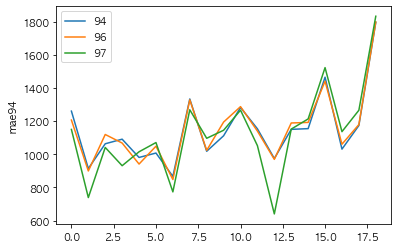

In [86]:
sns.lineplot(x =range(len(d_up)),y = d_up.mae94)
sns.lineplot(x =range(len(d_up)),y = d_up.mae96)
sns.lineplot(x =range(len(d_up)),y = d_up.mae97)
plt.legend(("94","96","97"))
plt.show()

In [103]:
d_up = d_up.sort_values("mae96")

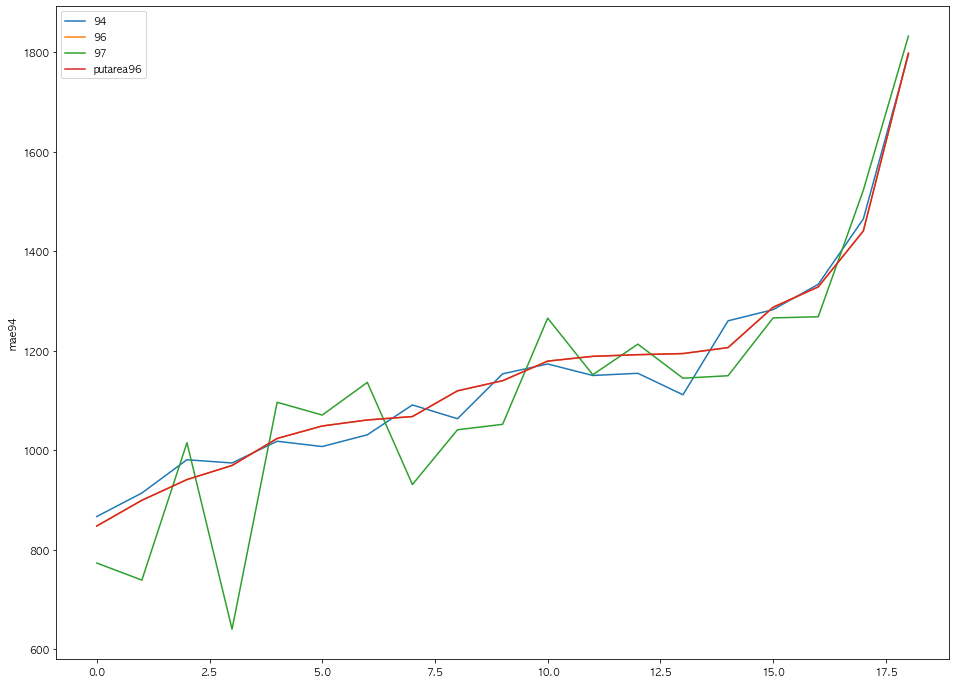

In [104]:
plt.figure(figsize=(16,12))
sns.lineplot(x =range(len(d_up)),y = d_up.mae94)
sns.lineplot(x =range(len(d_up)),y = d_up.mae96)
sns.lineplot(x =range(len(d_up)),y = d_up.mae97)
sns.lineplot(x =range(len(d_up)),y = d_up.putarea)
plt.legend(("94","96","97","putarea96"))
plt.show()

In [ ]:
sns.kdeplot(data = d_up, )

In [46]:
d_up = d_up.sort_values("mae96")

In [ ]:
sns.lineplot(x =range(len(d_up)),y = d_up.mae94)
sns.lineplot(x =range(len(d_up)),y = d_up.mae96)
plt.legend(("94","96"))
plt.show()